# This script performs the analysis in the supplemental Figures S3 - S5:
### Single parameter bifurcation diagrams with no harvest, predator harvest ($E_P$=0.4), and across interaction strength

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

# Pred - Prey Model Functions

In [2]:
def dNdt(H, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    
    return dH, dP

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, parameters_dict):
    H_init = H
    P_init = P 
    
    dH1, dP1 = dNdt(H,P,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    
    dH2, dP2 = dNdt(H1,P1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, herbivore_harvest, predator_harvest

In [4]:
# Function to run the model 

def run_model(INIT_H, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, H_harvest_array, P_harvest_array

## Run Model and Test Time Series

In [5]:
numyears = 1000 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.4 # growth rate of herbivores
K_H = 5000 # carrying capacity of herbivores
theta_H = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_H = 1. # proportionality constant for herbivore harvest 
E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.0 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

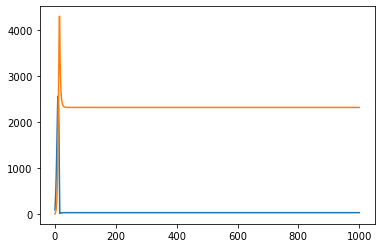

In [6]:
plt.plot(H_array)
plt.plot(P_array)

# Figure S3 - Single Parameter Bifurcations, no harvest 

In [7]:
## Define function to compute single param bifurcation
def compute_bifurcation_data(param_name, param_vals, fixed_params, H0, P0, sample_window=100, min_cycle_amp=1.0):
    H_means, H_maxs, H_mins, H_cycle_center = [], [], [], []
    P_means, P_maxs, P_mins, P_cycle_center = [], [], [], []

    for val in param_vals:
        params = fixed_params.copy()
        params[param_name] = val

        H_array, P_array, *_ = run_model(H0, P0, params)
        H_tail = H_array[-sample_window:]
        P_tail = P_array[-sample_window:]

        H_amp = np.ptp(H_tail)
        P_amp = np.ptp(P_tail)

        if H_amp < min_cycle_amp:
            H_means.append(np.mean(H_tail))
            H_maxs.append(np.nan)
            H_mins.append(np.nan)
            H_cycle_center.append(np.nan)
        else:
            H_means.append(np.nan)
            H_maxs.append(np.max(H_tail))
            H_mins.append(np.min(H_tail))
            H_cycle_center.append(np.mean(H_tail))

        if P_amp < min_cycle_amp:
            P_means.append(np.mean(P_tail))
            P_maxs.append(np.nan)
            P_mins.append(np.nan)
            P_cycle_center.append(np.nan)
        else:
            P_means.append(np.nan)
            P_maxs.append(np.max(P_tail))
            P_mins.append(np.min(P_tail))
            P_cycle_center.append(np.mean(P_tail))

    return {
        'param_vals': np.array(param_vals),
        'H_means': np.array(H_means),
        'H_maxs': np.array(H_maxs),
        'H_mins': np.array(H_mins),
        'H_cycle_center': np.array(H_cycle_center),
        'P_means': np.array(P_means),
        'P_maxs': np.array(P_maxs),
        'P_mins': np.array(P_mins),
        'P_cycle_center': np.array(P_cycle_center),
    }

# Parameter sweeps 
param_sweeps = {
    #'E_H': np.linspace(0, 1.0, 200),
    'K_H': np.linspace(100, 7000, 200),
    'K_P': np.linspace(100, 7000, 200),
    'b': np.linspace(0, 1.0, 200),
    'c': np.linspace(0, 1.0, 200),
    'r_H': np.linspace(0, 1.0, 200),
    'r_P': np.linspace(0, 1.0, 200),
}

# Default parameters, no harvest
default_params = {
    'numyears': 400,
    'r_H': 0.4,
    'K_H': 5000,
    'theta_H': 50,
    'c': 0.4,
    'd': 500,
    'q_H': 1.0,
    'E_H': 0.0,
    'r_P': 0.2,
    'K_P': 2000,
    'b': 0.4,
    'theta_P': 10,
    'q_P': 1.0,
    'E_P': 0.0,
}

# LaTeX label mapping for display
latex_labels = {
    'E_H': r'$E_N$',
    'K_H': r'$K_N$',
    'K_P': r'$K_P$',
    'b': r'$b$',
    'c': r'$c$',
    'r_H': r'$r_N$',
    'r_P': r'$r_P$',
}

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


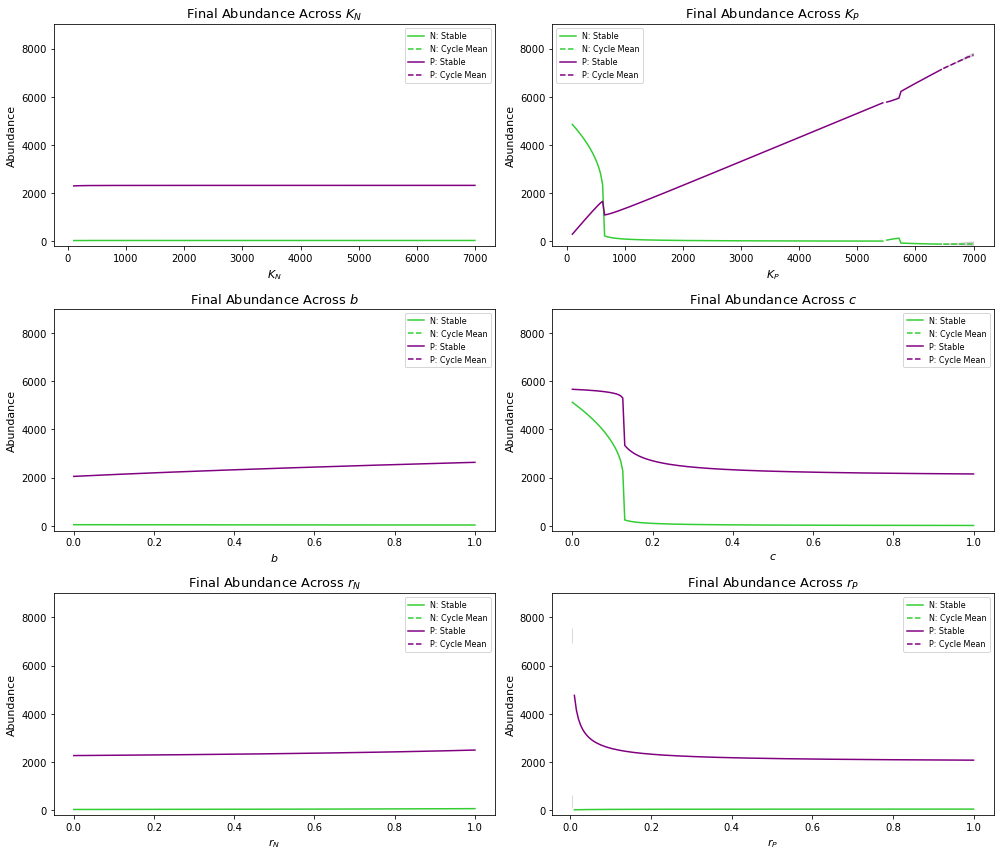

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for idx, (param_name, param_vals) in enumerate(param_sweeps.items()):
    data = compute_bifurcation_data(param_name, param_vals, default_params, H0=100, P0=10)
    ax = axs[idx]

    # Plot prey (N)
    ax.plot(data['param_vals'], data['H_means'], '-', label='N: Stable', color='limegreen')
    ax.plot(data['param_vals'], data['H_cycle_center'], '--', label='N: Cycle Mean', color='limegreen')
    ax.fill_between(data['param_vals'], data['H_mins'], data['H_maxs'],
                    where=~np.isnan(data['H_cycle_center']), color='gray', alpha=0.3)

    # Plot predator (P)
    ax.plot(data['param_vals'], data['P_means'], '-', label='P: Stable', color='purple')
    ax.plot(data['param_vals'], data['P_cycle_center'], '--', label='P: Cycle Mean', color='purple')
    ax.fill_between(data['param_vals'], data['P_mins'], data['P_maxs'],
                    where=~np.isnan(data['P_cycle_center']), color='gray', alpha=0.3)

    ax.set_ylim(-200, 9000)
    ax.set_ylabel("Abundance", fontsize=11)

    # Use LaTeX for x-labels and titles
    latex_label = latex_labels.get(param_name, param_name)
    ax.set_xlabel(latex_label, fontsize=11)
    ax.set_title(f'Final Abundance Across {latex_label}', fontsize=13)
    ax.legend(fontsize=8)
    
# Hide any unused subplot axes
for ax in axs[len(param_sweeps):]:
    ax.axis('off')
    
plt.tight_layout()

plt.savefig("manuscript_figs/S3_bifurcations_no_harvest.jpg",
            format='jpeg',
            dpi=300,
    bbox_inches='tight')

plt.show()

# Figure S4 - Single Parameter Bifurcations, predator harvest ($E_P$ = 0.4)

In [9]:
# Parameter sweep setup
param_sweeps = {
    'K_H': np.linspace(100, 7000, 200),
    'K_P': np.linspace(100, 7000, 200),
    'b': np.linspace(0, 1.0, 200),
    'c': np.linspace(0, 1.0, 200),
    'r_H': np.linspace(0, 1.0, 200),
    'r_P': np.linspace(0, 1.0, 200),
}

# Default parameters, with harvest
default_params = {
    'numyears': 400,
    'r_H': 0.4,
    'K_H': 5000,
    'theta_H': 50,
    'c': 0.4,
    'd': 500,
    'q_H': 1.0,
    'E_H': 0.0,
    'r_P': 0.2,
    'K_P': 2000,
    'b': 0.4,
    'theta_P': 10,
    'q_P': 1.0,
    'E_P': 0.4,
}

# LaTeX label mapping for display
latex_labels = {
    'E_H': r'$E_N$',
    'K_H': r'$K_N$',
    'K_P': r'$K_P$',
    'b': r'$b$',
    'c': r'$c$',
    'r_H': r'$r_N$',
    'r_P': r'$r_P$',
}

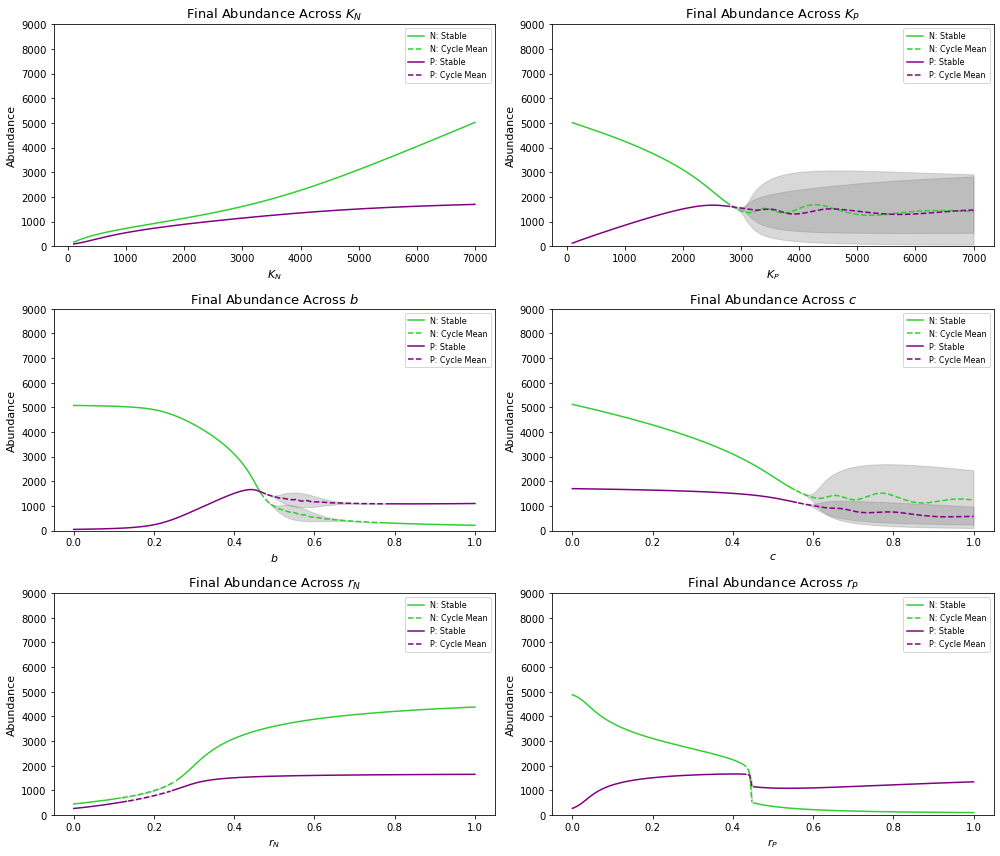

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for idx, (param_name, param_vals) in enumerate(param_sweeps.items()):
    data = compute_bifurcation_data(param_name, param_vals, default_params, H0=100, P0=10)
    ax = axs[idx]

    # Plot prey (N)
    ax.plot(data['param_vals'], data['H_means'], '-', label='N: Stable', color='limegreen')
    ax.plot(data['param_vals'], data['H_cycle_center'], '--', label='N: Cycle Mean', color='limegreen')
    ax.fill_between(data['param_vals'], data['H_mins'], data['H_maxs'],
                    where=~np.isnan(data['H_cycle_center']), color='gray', alpha=0.3)

    # Plot predator (P)
    ax.plot(data['param_vals'], data['P_means'], '-', label='P: Stable', color='purple')
    ax.plot(data['param_vals'], data['P_cycle_center'], '--', label='P: Cycle Mean', color='purple')
    ax.fill_between(data['param_vals'], data['P_mins'], data['P_maxs'],
                    where=~np.isnan(data['P_cycle_center']), color='gray', alpha=0.3)

    ax.set_ylim(0, 9000)
    ax.set_ylabel("Abundance", fontsize=11)

    # Use LaTeX for x-labels and titles
    latex_label = latex_labels.get(param_name, param_name)
    ax.set_xlabel(latex_label, fontsize=11)
    ax.set_title(f'Final Abundance Across {latex_label}', fontsize=13)
    ax.legend(fontsize=8)
    
# Hide any unused subplot axes
for ax in axs[len(param_sweeps):]:
    ax.axis('off')
    
plt.tight_layout()

plt.savefig("manuscript_figs/S4_bifurcations_with_harvest.jpg",
            format='jpeg',
            dpi=300,
    bbox_inches='tight')

plt.show()

# Figure S5 - Bifurcation of $E_P$ under different $b$, $c$

#### Define default params

In [11]:
def default_params():
    numyears = 1000
    #Herbivore parameters:
    r_H = 0.4 # growth rate of herbivores
    K_H = 5000 # carrying capacity of herbivores
    theta_H = 50 # immigration of herbivores
    c = 0.4 #additional mortality of H 
    d = 500 # value of H when predation half its max value 
    q_H = 1. # proportionality constant for herbivore harvest 
    E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
    #Predator parameters:
    r_P = 0.2 # growth rate of predator 
    K_P = 2000 # carrying capactiy of predators
    b = 0.4 # additional growth of P due to H
    theta_P = 10 # immigration of predators 
    q_P = 1. # proportionality constant for predator harvest 
    E_P = 0.0 # Effort for predator harvest

    parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

    return parameters_dict

## Calculate and plot

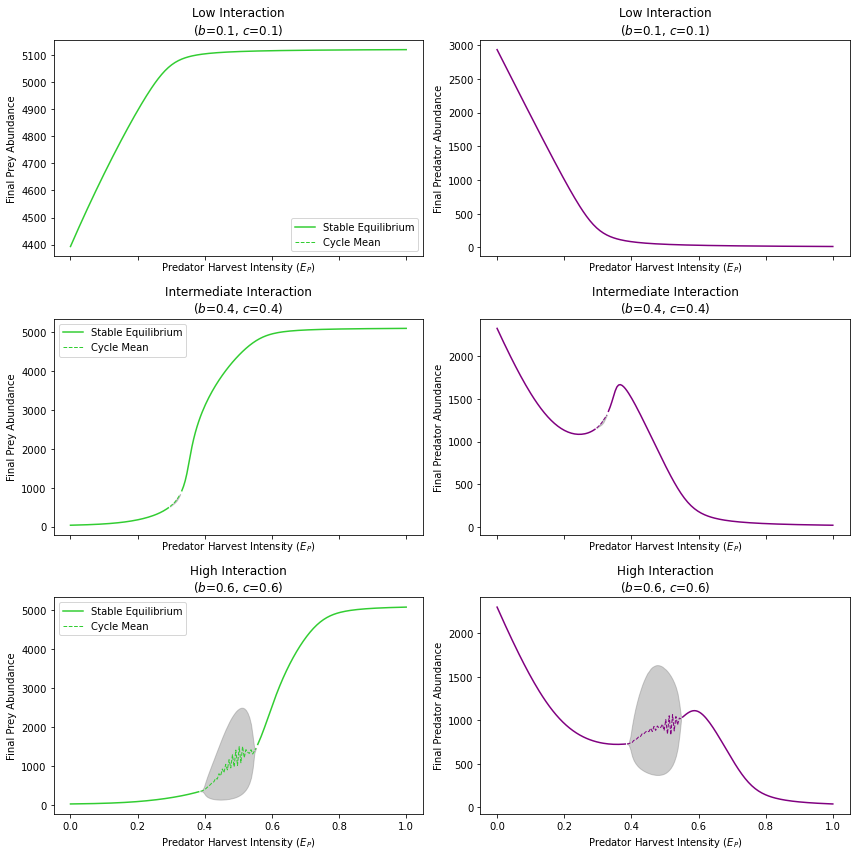

In [12]:
E_P_vals = np.linspace(0, 1.0, 200)
sample_window = 50
min_cycle_amp = 1.0

# Containers for prey and predator data
H_traj_points, P_traj_points = [], []
E_P_record = []

H_means, H_maxs, H_mins, H_cycle_center = [], [], [], []
P_means, P_maxs, P_mins, P_cycle_center = [], [], [], []

# Extend the interaction settings to include high interaction for the third row
interaction_settings = [
    {'b': 0.1, 'c': 0.1, 'label': 'Low Interaction\n($b$=0.1, $c$=0.1)'},
    {'b': 0.4, 'c': 0.4, 'label': 'Intermediate Interaction\n($b$=0.4, $c$=0.4)'},
    {'b': 0.6, 'c': 0.6, 'label': 'High Interaction\n($b$=0.6, $c$=0.6)'},
]

parameters_dict = default_params()

# Prepare figure for 3 rows x 1 column
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
axs = axs.reshape(3, 2)

for row, setting in enumerate(interaction_settings):
    b, c = setting['b'], setting['c']
    label = setting['label']

    H_means, H_maxs, H_mins, H_cycle_center = [], [], [], []
    P_means, P_maxs, P_mins, P_cycle_center = [], [], [], []

    for ep in E_P_vals:
        parameters_dict['E_P'] = ep
        parameters_dict['b'] = b
        parameters_dict['c'] = c

        H_array, P_array, *_ = run_model(H0, P0, parameters_dict)
        H_tail = H_array[-sample_window:]
        P_tail = P_array[-sample_window:]

        H_amp = np.ptp(H_tail)
        P_amp = np.ptp(P_tail)

        if H_amp < min_cycle_amp:
            H_means.append(np.mean(H_tail))
            H_maxs.append(np.nan)
            H_mins.append(np.nan)
            H_cycle_center.append(np.nan)
        else:
            H_means.append(np.nan)
            H_maxs.append(np.max(H_tail))
            H_mins.append(np.min(H_tail))
            H_cycle_center.append(np.mean(H_tail))

        if P_amp < min_cycle_amp:
            P_means.append(np.mean(P_tail))
            P_maxs.append(np.nan)
            P_mins.append(np.nan)
            P_cycle_center.append(np.nan)
        else:
            P_means.append(np.nan)
            P_maxs.append(np.max(P_tail))
            P_mins.append(np.min(P_tail))
            P_cycle_center.append(np.mean(P_tail))

    # Convert to arrays
    H_means = np.array(H_means)
    H_maxs = np.array(H_maxs)
    H_mins = np.array(H_mins)
    H_cycle_center = np.array(H_cycle_center)

    P_means = np.array(P_means)
    P_maxs = np.array(P_maxs)
    P_mins = np.array(P_mins)
    P_cycle_center = np.array(P_cycle_center)

    # Prey subplot
    ax_H = axs[row, 0]
    ax_H.plot(E_P_vals, H_means, 'k-', label="Stable Equilibrium", color="limegreen")
    ax_H.plot(E_P_vals, H_cycle_center, 'k--', linewidth=1.0, label="Cycle Mean", color="limegreen")
    ax_H.fill_between(E_P_vals, H_mins, H_maxs, where=~np.isnan(H_cycle_center), color='gray', alpha=0.4)
    ax_H.set_ylabel('Final Prey Abundance')
    ax_H.set_xlabel('Predator Harvest Intensity ($E_P$)')
    ax_H.set_title(label)
    ax_H.legend()

    # Predator subplot
    ax_P = axs[row, 1]
    ax_P.plot(E_P_vals, P_means, 'k-', color="purple")
    ax_P.plot(E_P_vals, P_cycle_center, 'k--', linewidth=1.0, color="purple")
    ax_P.fill_between(E_P_vals, P_mins, P_maxs, where=~np.isnan(P_cycle_center), color='gray', alpha=0.4)
    ax_P.set_title(label)
    ax_P.set_ylabel('Final Predator Abundance')
    ax_P.set_xlabel('Predator Harvest Intensity ($E_P$)')

plt.tight_layout()

plt.savefig("manuscript_figs/S5_EP_bifurcations.jpg",
            format='jpeg',
            dpi=300,
    bbox_inches='tight')

plt.show()